In [54]:
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from keras.layers import PReLU
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, Input, Flatten, Conv1D,Dropout, MaxPooling1D
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
import random


In [42]:
# Loading data
data_folder = 'data/P_data'
data_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

data_dict = {}

for file in data_files:
    name = file.split('.')[0]
    data = pd.read_csv(os.path.join(data_folder,file))
    data_dict[name] = data

bray_global = data_dict['bray_global']
bray_afrlac = data_dict['bray_afrlac']
olsen_global = data_dict['olsen_global']
olsen_afrlac = data_dict['olsen_afrlac']
stp_global = data_dict['stp_global']
stp_afrlac = data_dict['stp_afrlac']

# Instantiate the encoder
encoder = LabelEncoder()

# Check if 'WRB.SOIL.TYPE' exists in the DataFrame, then transform it
if 'WRB.SOIL.TYPE' in stp_global.columns:
    stp_global['WRB.SOIL.TYPE'] = encoder.fit_transform(stp_global['WRB.SOIL.TYPE'])
if 'WRB.SOIL.TYPE' in stp_afrlac.columns:
    stp_afrlac['WRB.SOIL.TYPE'] = encoder.transform(stp_afrlac['WRB.SOIL.TYPE'])  # use transform, not fit_transform

In [43]:
def prepare_data(df):
    # Separate the predictors and response
    X = df.drop(['p_avg', 'LONGITUDE', 'LATITUDE', 'GEO3major'], axis=1).values
    y = df['p_avg'].values

    return X, y

# Prepare the datasets
X_bray_global, y_bray_global = prepare_data(bray_global)
X_bray_afrlac, y_bray_afrlac = prepare_data(bray_afrlac)
X_olsen_afrlac, y_olsen_afrlac = prepare_data(olsen_afrlac)
X_olsen_global, y_olsen_global = prepare_data(olsen_global)
X_stp_afrlac, y_stp_afrlac = prepare_data(stp_afrlac)
X_stp_global, y_stp_global = prepare_data(stp_global)


In [39]:
def run_dnn(dataset_name, X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the DNN model
    model = Sequential()
    model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.05))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.05))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.04))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fit the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

    # Evaluate the model
    mse = model.evaluate(X_test, y_test)
    print("Mean squared error:", mse)

    # Calculate and print the correlation coefficients
    corr_train = np.corrcoef(y_train, model.predict(X_train).flatten())[0, 1]
    corr_test = np.corrcoef(y_test, model.predict(X_test).flatten())[0, 1]
    print("Correlation coefficient for training data:", corr_train)
    print("Correlation coefficient for test data:", corr_test)

    # Create a directory for the results using the dataset name
    output_folder = dataset_name
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Save the correlations to a text file
    correlation_text = f"Correlation coefficient for training data: {corr_train}\nCorrelation coefficient for test data: {corr_test}"
    with open(os.path.join(output_folder, f"correlations.txt"), "w") as f:
        f.write(correlation_text)

    # For the whole data
    # Get the predictions
    y_train_pred = model.predict(X_train).flatten()
    y_test_pred = model.predict(X_test).flatten()

    # Concatenate the actual values
    y = np.concatenate((y_train, y_test))

    # Concatenate the predicted values
    y_pred = np.concatenate((y_train_pred, y_test_pred))

    # Calculate the correlation
    corr = np.corrcoef(y, y_pred)[0, 1]
    print('Correlation for the whole data:', corr)

    # Plot the training and validation loss
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(output_folder, f"loss.png"))
    plt.close()

    # Get the predictions for the test data
    y_test_pred = model.predict(X_test).flatten()
    print(y_test_pred)

    # Plot the predicted vs actual values
    plt.scatter(y_test, y_test_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Predicted vs Actual Values')
    plt.savefig(os.path.join(output_folder, 'predicted_vs_actual.png'))
    plt.close()
    
    
    # Get random indices for selecting samples
    random_indices = np.random.choice(len(X_train), size=10, replace=False)

    # Select random samples from training data
    X_train_random = X_train[random_indices]
    y_train_random = y_train[random_indices]
    y_train_pred_random = y_train_pred[random_indices]

    # Plot the predicted vs actual values
    fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(8, 20))
    for i in range(10):
        axs[i, 0].plot(X_test[i])
        axs[i, 0].set_title("Actual")
        axs[i, 1].plot(y_pred[i])
        axs[i, 1].set_title("Predicted")

    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'predicted_vs_actual.png'))
    plt.close()
    
    # Flatten the arrays
    X_test_flattened = X_test.flatten()
    y_pred_flattened = y_pred.flatten()

    # Create a DataFrame with actual and predicted values
    df = pd.DataFrame({'Actual': X_test_flattened[:len(y_pred_flattened)], 'Predicted': y_pred_flattened})

    # Save the DataFrame as a CSV file
    df.to_csv(os.path.join(output_folder, 'actual_predicted.csv'), index=False)

In [40]:
# Example usage
dataset_name = 'bray_global'
X = X_bray_global
y = y_bray_global
output_folder = dataset_name

run_dnn(dataset_name, X, y)

83/83 [==============================] - 0s 781us/step - loss: 505.8027
Mean squared error: 505.8027038574219
83/83 [==============================] - 0s 596us/step
Correlation coefficient for training data: 0.6210008761430295
Correlation coefficient for test data: 0.5637696411535814
83/83 [==============================] - 0s 639us/step
Correlation for the whole data: 0.6093979100593973
83/83 [==============================] - 0s 592us/step
[60.563602  11.525936  10.902521  ...  8.1352825 11.896137  70.59645  ]


In [44]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_bray_global, y_bray_global

NameError: name 'X_train' is not defined

In [65]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_bray_afrlac, y_bray_afrlac, test_size=0.2, random_state=42)

In [145]:
# Define the DNN model
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(16, activation='relu'))
#model.add(Dense(8, activation='relu'))

model.add(Dense(1, activation='relu'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

In [167]:
# Define the DNN model
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))

model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(16, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dense(8, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

In [172]:
# Calculate and print the correlation coefficients
corr_train = np.corrcoef(y_train, model.predict(X_train).flatten())[0, 1]
corr_test = np.corrcoef(y_test, model.predict(X_test).flatten())[0, 1]

# Correlation for the whole data 
y_train_pred = model.predict(X_train).flatten()
y_test_pred = model.predict(X_test).flatten()
# Concatenate the actual values
y = np.concatenate((y_train, y_test))
# Concatenate the predicted values
y_pred = np.concatenate((y_train_pred, y_test_pred))
# Calculate the correlation
corr = np.corrcoef(y, y_pred)[0, 1]


# Calculate metrics for training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Calculate metrics for test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Calculate R-squared for training set
ss_total = np.sum((y_train - np.mean(y_train))**2)
ss_residual = np.sum((y_train - y_train_pred)**2)
r2_train = 1 - (ss_residual / ss_total)

# Calculate Adjusted R-squared for training set
n_train = len(y_train)
p_train = 1  # Number of predictors in the model
adj_r2_train = 1 - (1 - r2_train) * ((n_train - 1) / (n_train - p_train - 1))

# Calculate R-squared for test set
ss_total = np.sum((y_test - np.mean(y_test))**2)
ss_residual = np.sum((y_test - y_test_pred)**2)
r2_test = 1 - (ss_residual / ss_total)

# Calculate Adjusted R-squared for test set
n_test = len(y_test)
p_test = 1  # Number of predictors in the model
adj_r2_test = 1 - (1 - r2_test) * ((n_test - 1) / (n_test - p_test - 1))

# Calculate Mean Percentage Error (MPE) for test set
mpe = np.mean((y_test - y_test_pred) / y_test) * 100

# Calculate Mean Absolute Percentage Error (MAPE) for test set
mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100


# Print the metrics
print("Correlation coefficient for training data: ", corr_train)
print("Correlation coefficient for test data: ", corr_test)
print()
print('Correlation for the whole data: ', corr)
print()


print("Training set:")
print("R-squared:", r2_train)
print("Adjusted R-squared:", adj_r2_train)
print()
print("Test set:")
print("R-squared:", r2_test)
print("Adjusted R-squared:", adj_r2_test)
print("Mean Percentage Error (MPE):", mpe)
print("Mean Absolute Percentage Error (MAPE):", mape)
print()

# Print the metrics
print("Training set:")
print("MSE:", train_mse)
print("RMSE:", train_rmse)
print("MAE:", train_mae)
print()
print("Test set:")
print("MSE:", test_mse)
print("RMSE:", test_rmse)
print("MAE:", test_mae)

2/2 [==============================] - 0s 3ms/step


2023-05-12 09:50:29.471840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-12 09:50:29.472861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-12 09:50:29.473950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 3ms/step
Correlation coefficient for training data:  0.3762854860368399
Correlation coefficient for test data:  -0.02090355089717926

Correlation for the whole data:  0.2869129859151204

Training set:
R-squared: 0.040638370760448295
Adjusted R-squared: 0.035508094668258106

Test set:
R-squared: -0.007703468492291421
Adjusted R-squared: -0.029610065633428384
Mean Percentage Error (MPE): -409.2734069047519
Mean Absolute Percentage Error (MAPE): 438.43695879500126

Training set:
MSE: 523.4786436772774
RMSE: 22.87965567217473
MAE: 16.607491392105345

Test set:
MSE: 617.7895463758224
RMSE: 24.85537258573732
MAE: 15.186136436462403


In [ ]:
Metrics:

Both the training and test sets show similar values for MSE, RMSE, and MAE. This indicates that the model's performance is consistent on both sets.
The MSE and RMSE values are relatively high, indicating that there is still room for improvement in reducing the prediction errors.
The MAE value suggests that, on average, the predicted values deviate by approximately 15.57 to 15.80 units from the actual values.
Correlation coefficients:

The correlation coefficient measures the linear relationship between the predicted and actual values.
A correlation coefficient of 0.4658 for the training set and 0.4683 for the test set indicate a moderate positive correlation. However, the correlation is not very strong, suggesting that the model's predictions do not perfectly match the actual values.

Based on these results, it appears that the model is performing similarly on both the training and test sets, which is a positive sign. However, the relatively high MSE and RMSE values suggest that there is still room for improvement in reducing the prediction errors. Additionally, the moderate correlation coefficients indicate that the model's predictions are somewhat aligned with the actual values but not perfectly accurate.

In [58]:
y_test

array([ 78.,  11.,  17., ...,  19.,   2., 136.])

In [50]:
y_pred

array([32.142017, 23.457785, 21.517666, ..., 32.41452 , 13.122116,
       46.223167], dtype=float32)

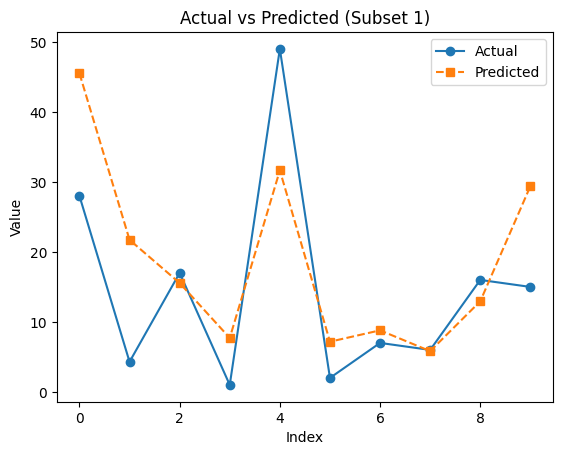

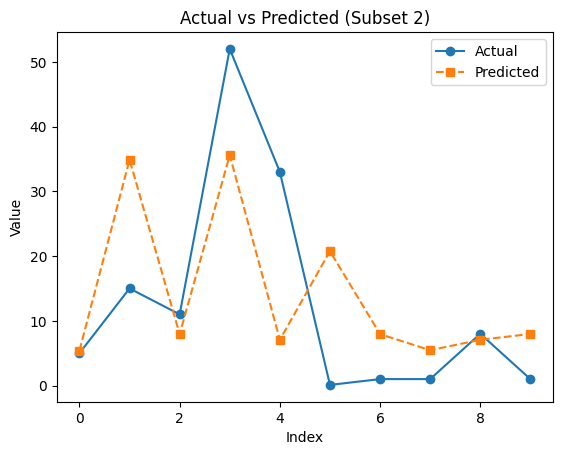

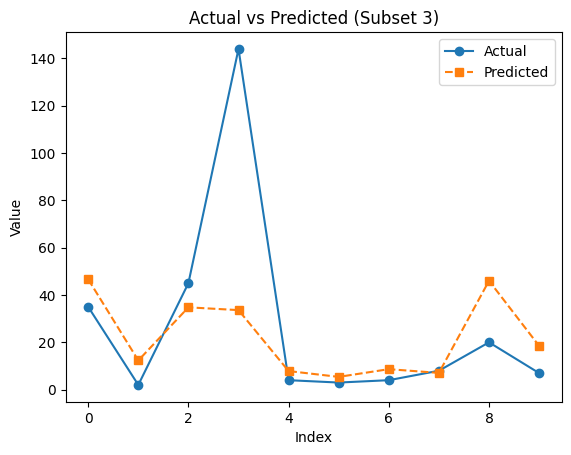

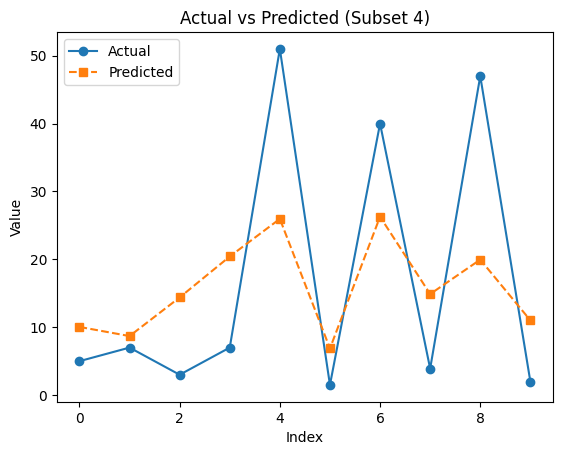

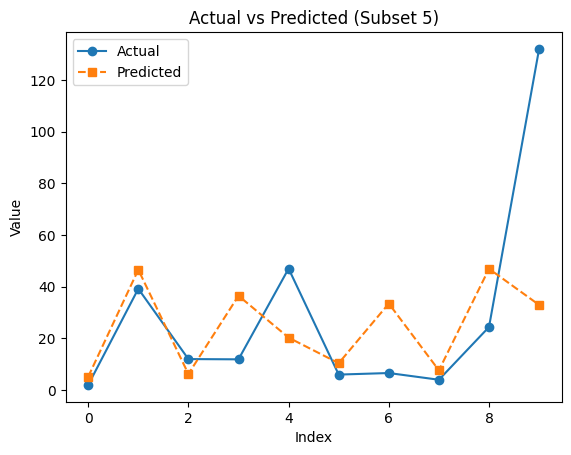

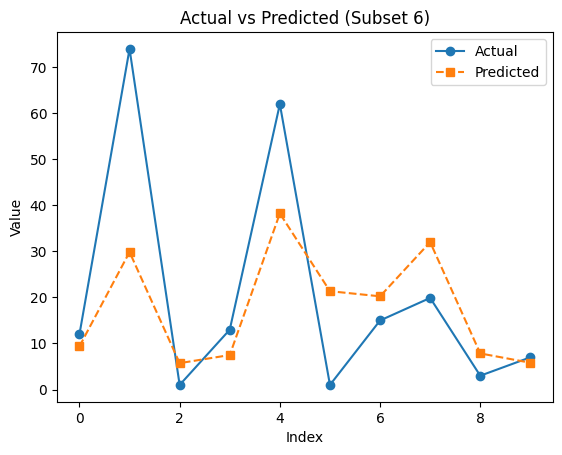

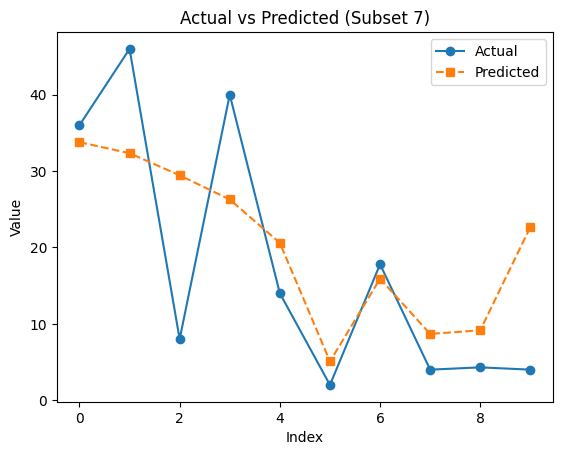

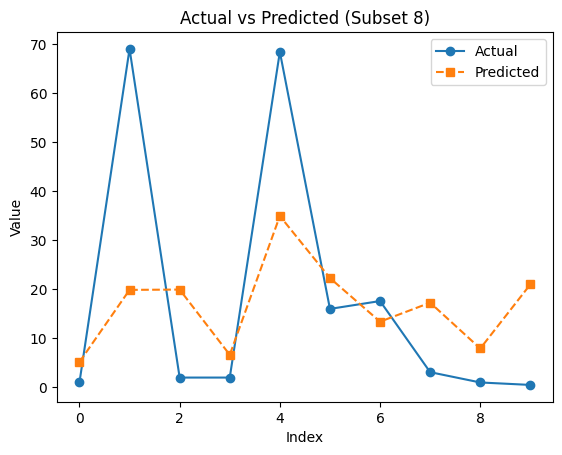

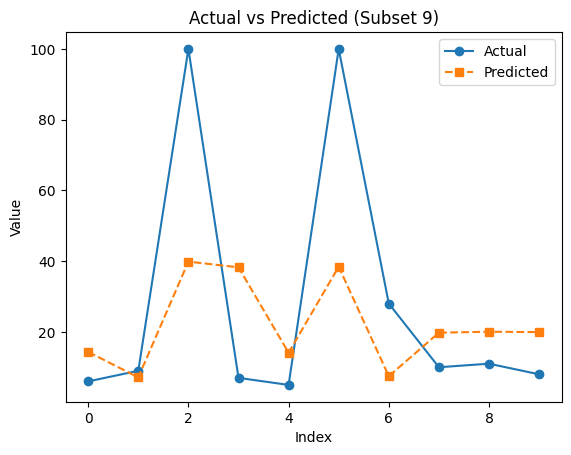

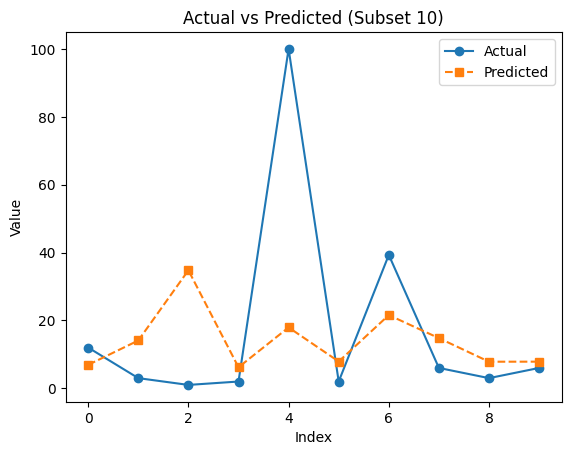

In [59]:
# Plotting the subsets in different graphs
for i in range(10):
    random_indices = random.sample(range(len(y_test)), k=10)
    y_subset = [y_test[j] for j in random_indices]
    y_pred_subset = [y_test_pred[j] for j in random_indices]

    # Create a new figure and subplot for each subset
    plt.figure(i+1)
    plt.plot(y_subset, label='Actual', linestyle='-', marker='o')
    plt.plot(y_pred_subset, label='Predicted', linestyle='--', marker='s')

    # Adding labels and title
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(f'Actual vs Predicted (Subset {i+1})')

    # Adding legend
    plt.legend()

# Display all the plots
plt.show()